In [1]:
import pandas
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import numpy as np
import torch
from torch import nn

/home/ahbagheri/anaconda3/envs/ml/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import sys
print(sys.executable)

/home/ahbagheri/anaconda3/envs/ml/bin/python


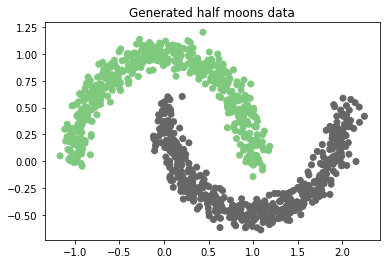

In [3]:
n_samples = 1000  # number of samples to generate
noise = 0.08 # noise to add to sample locations
x, y = datasets.make_moons(n_samples=n_samples, noise=noise)
plt.scatter(*x.T, c=y, cmap=plt.cm.Accent)
plt.title("Generated half moons data");

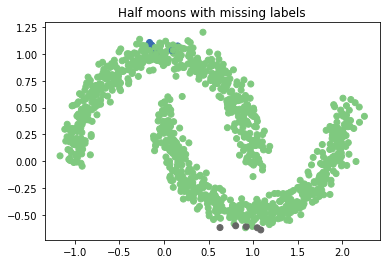

In [4]:
unlabeled_frac = 0.99  # fraction of data to drop labels
y_ssml = y.copy()
zero_indexs = np.where(y == 0)[0]
one_indexs = np.where(y == 1)[0]
y_ssml[:] = -1
unlabeled = np.random.choice(np.where(x[:,1] >= 1 )[0], size=int((1-unlabeled_frac) * len(zero_indexs)), replace=False)
y_ssml[unlabeled] = 0  # set missing labels to -1
unlabeled = np.random.choice(np.where(x[:,1] <= -0.60)[0], size=int((1-unlabeled_frac) * len(one_indexs)), replace=False)
y_ssml[unlabeled] = 1  # set missing labels to -1
plt.scatter(*x.T, c=y_ssml, cmap=plt.cm.Accent)
plt.title("Half moons with missing labels");


In [7]:
index = (y_ssml == -1)
unlabeldX = x[index]
labaled = x[~index]
Y = y_ssml[~index]
xval, yval = datasets.make_moons(n_samples= int(n_samples/10), noise=noise)
evalindex = np.where((xval[:,1] >= -0.5) & (xval[:,1] < 1))[0]
xval = xval[evalindex]
yval = yval[evalindex]

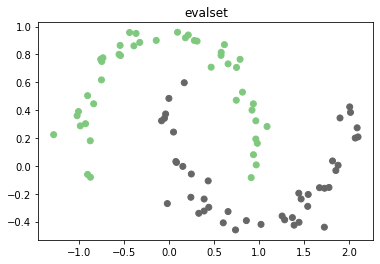

In [8]:
plt.scatter(*xval.T, c=yval, cmap=plt.cm.Accent)
plt.title("evalset");

In [40]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
        torch.nn.Linear(2, 20),
        torch.nn.ReLU(),
        nn.BatchNorm1d(20),
        torch.nn.Linear(20, 20),
        torch.nn.ReLU(),
        nn.BatchNorm1d(20),
        torch.nn.Linear(20, 20),
        torch.nn.ReLU(),
        nn.BatchNorm1d(20),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid())
    def forward(self,x):
        return self.model(x)

def update_teacher(teacher, student, alpha = 0.2):
    for tparam, param in zip(teacher.parameters(), student.parameters()):
            tparam.data[:] = alpha * tparam.data[:] + (1 - alpha) * param[:].data[:]
    return teacher

def batch_sampler(X,XL,y, bl = 128, bu = 128):
    uindex1 = np.random.choice(range(len(X)), size= min(bu,len(X)), replace=False)
    uindex2 = np.random.choice(range(len(X)), size= min(bu,len(X)), replace=False)
    lindex = np.random.choice(range(len(XL)), size= min(bl,len(XL)), replace=False)
    return torch.tensor(X[uindex1], dtype = torch.float),torch.tensor(X[uindex2],dtype = torch.float),torch.tensor(XL[lindex],dtype = torch.float),torch.tensor(y[lindex],dtype = torch.float)

def batch_loader(X,XL,y, bl = 512):
    uindex1 = np.random.choice(range(len(X)), size= len(X), replace=False)
    lindex = np.random.choice(range(len(XL)), size= len(XL), replace=False)
    X = X[uindex1]
    XL = XL[lindex]
    y = y[lindex]
    for i in range(int(len(XL)/bl) + 1):
        xh = XL[i*bl:min(len(XL),(i+1)*bl)]
        yh = y[i*bl:min(len(XL),(i+1)*bl)]
        yield torch.tensor(xh, dtype = torch.float) , torch.tensor(yh,dtype = torch.float)

pytorch_total_params = sum(p.numel() for p in Classifier().parameters())
print(pytorch_total_params)

1041


In [41]:
student_model = Classifier()
teacher_model = Classifier()
optimizer = torch.optim.SGD(student_model.parameters(), lr=1e-3, momentum=0.9)

update_rate = 1e-1
w = lambda t : 100/(1+(1000) * np.exp(-t/10))
T = 10000
mix = lambda l,x1,x2 : l * x1 + (1-l) * x2

In [42]:
# train 
import copy
best_model = Classifier()
best_val = 0
for t in range(T):
    optimizer.zero_grad()
    student_model.train()
    teacher_model.eval()
    X1,X2,XL,yl = batch_sampler(unlabeldX, labaled, Y,3,1024)
    pre = student_model(XL).squeeze()
    #print(pre)
    losssup = nn.BCELoss()(pre,yl)
    
    with torch.no_grad():
        y1hat = teacher_model(X1)
        y2hat = teacher_model(X2)
        
    l = np.random.random()
    X = mix(l, X1,X2)
    yhat = mix(l, y1hat, y2hat)
    lossC = nn.MSELoss()(student_model(X),yhat)
    loss = losssup + w(t)* lossC
    loss.backward()
    teacher_model = update_teacher(teacher_model, student_model,update_rate)
    optimizer.step()
    with torch.no_grad():
        student_model.eval()
        p = 0
        t = 0
        for xh , yh in batch_loader(unlabeldX, xval, yval):
            prev = student_model(xh).squeeze() >= 0.5
            p += torch.sum(prev == yh)
            t += xh.shape[0]
        valacc = p/t
        if valacc > best_val:
            best_val = valacc
            best_model = copy.deepcopy(student_model)

In [43]:
student_model = Classifier()
teacher_model = Classifier()
optimizer = torch.optim.SGD(student_model.parameters(), lr=1e-3, momentum=0.9)

In [44]:
# train 
best_val = 0
for t in range(T):
    optimizer.zero_grad()
    student_model.train()
    teacher_model.eval()
    X1,X2,XL,yl = batch_sampler(unlabeldX, labaled, Y,128,512)
    pre = student_model(XL).squeeze()
    loss = nn.BCELoss()(pre,yl)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        student_model.eval()
        p = 0
        t = 0
        for xh , yh in batch_loader(unlabeldX, xval, yval):
            prev = student_model(xh).squeeze() >= 0.5
            p += torch.sum(prev == yh)
            t += xh.shape[0]
        valacc = p/t
        if valacc > best_val:
            best_val = valacc
            best_model2 = copy.deepcopy(student_model) 

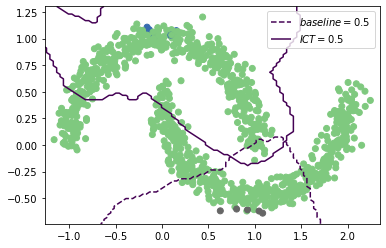

In [45]:
# Determine grid range
x0_min, x0_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
x1_min, x1_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1

# Create grid
x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                     np.linspace(x1_min, x1_max, 100))
grid = torch.FloatTensor(np.hstack((x0.reshape(-1, 1), x1.reshape(-1, 1))))

# Plot the data
plt.scatter(*x.T, c=y_ssml, cmap=plt.cm.Accent)

# Evaluate baseline on the grid and plot decision boundary
bl_pred = (best_model2(grid).squeeze() >= 0.5).numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, bl_pred, levels=[0.5], linestyles='--')
h1, l1 = cs.legend_elements("baseline")

eaat_pred = (best_model(grid).squeeze() >= 0.5).numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, eaat_pred, levels=[0.5])
h2, l2 = cs.legend_elements("ICT")

plt.legend(h1 + h2, l1 + l2)